This notebook tests that required modules can be imported. It also contains a few examples of the functions in `common.py` to initialize the fields, and calculations of the theoretical peaks that will be used in the following notebooks.

# Testing the setup

In [1]:
import os
# Remove warning when importing Taichi due to old glibc
os.environ["TI_MANYLINUX2014_OK"] = "1"

import numpy
import numba
import numexpr
import taichi
import matplotlib
import gt4py

[Taichi] version 1.6.0, llvm 16.0.0git, commit f1c6fbbd, linux, python 3.9.4


[I 08/23/23 12:10:52.653 6277] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


# Initializing fields

In [2]:
from common import initialize_fields, plot_field

In [3]:
NX = 128
NY = 128
NZ = 80

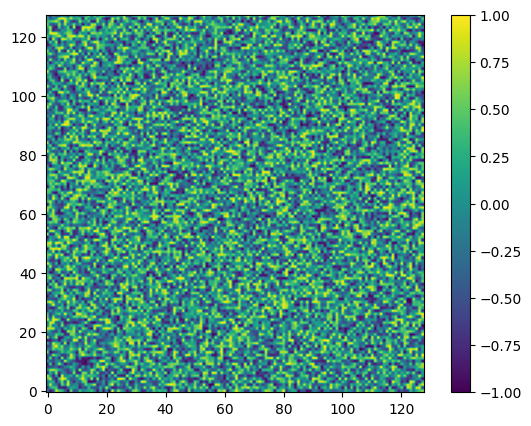

In [4]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="random")
plot_field(in_field)

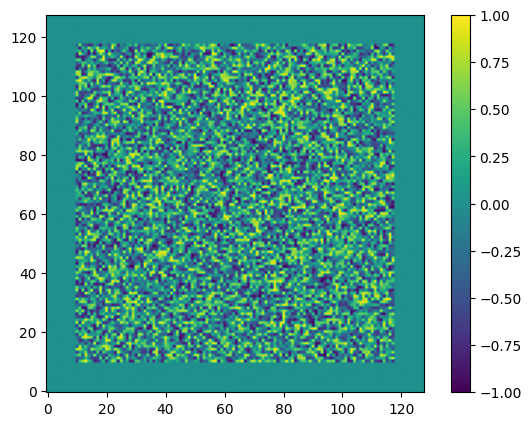

In [5]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="random", num_halo=10)
plot_field(in_field)

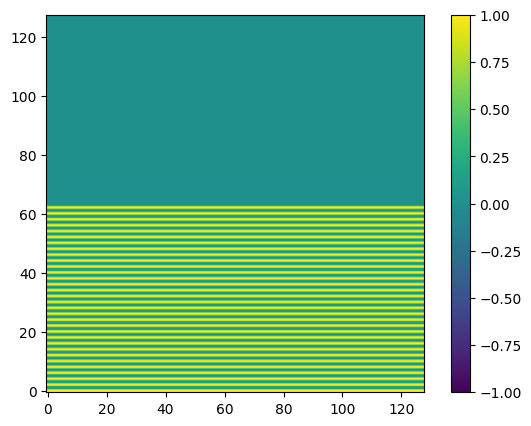

In [6]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
plot_field(in_field)

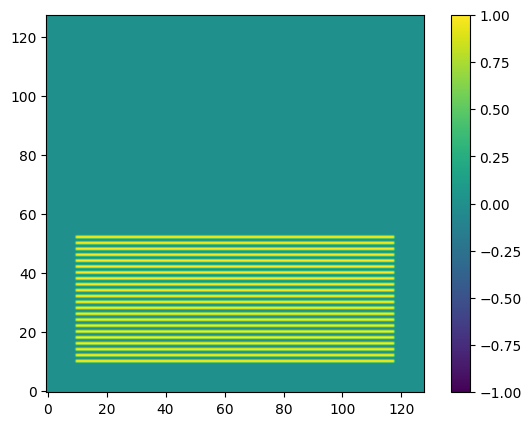

In [7]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", num_halo=10)
plot_field(in_field)

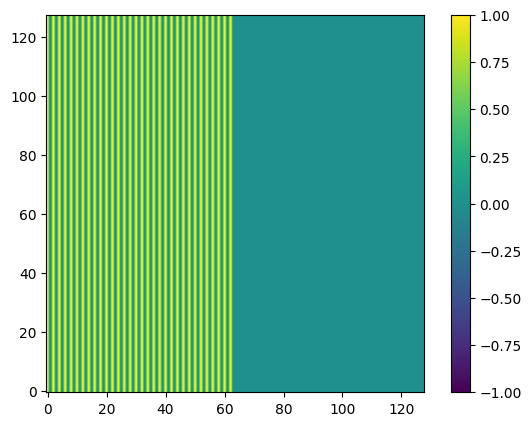

In [8]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
plot_field(in_field)

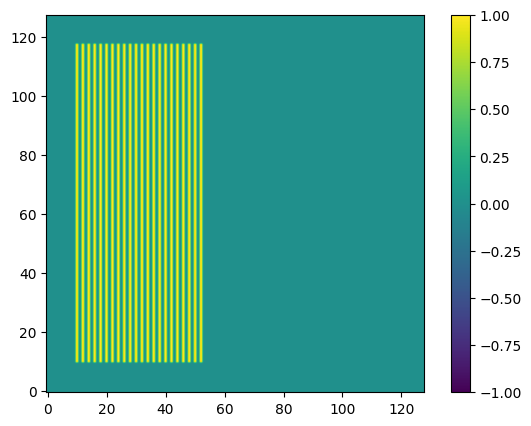

In [9]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", num_halo=10)
plot_field(in_field)

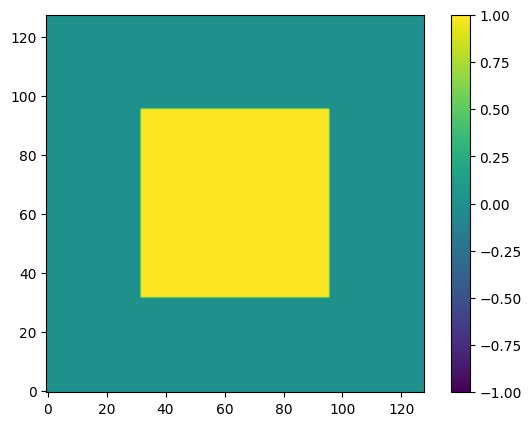

In [10]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
plot_field(in_field)

The underlying order of the dimensions in the NumPy arrays can be changed to any of the 6 possible permutations by using the kwarg `dim_order`. Plotting the field will still work as expected if we use the same kwarg there.

(80, 128, 128)

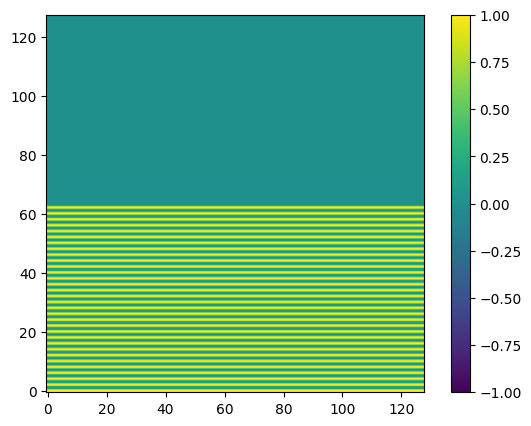

In [11]:
dim_order = "ZXY"
in_field, out_field = initialize_fields(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(in_field, dim_order=dim_order)
in_field.shape

(128, 80, 128)

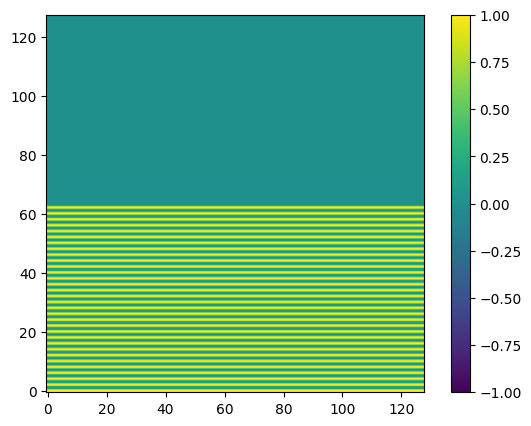

In [12]:
dim_order = "YZX"
in_field, out_field = initialize_fields(NX, NY, NZ, dim_order=dim_order, mode="horizontal-bars")
plot_field(in_field, dim_order=dim_order)
in_field.shape

# Theoretical peaks

TODO